# <b> <center>Magnificent 7 Backtesting  </center></b>

A challenge to do backtesting of datasets without using any backtesting frameworks

### <b>Importing Python Libraries</b>

In [ ]:
import yfinance as yf # https://github.com/ranaroussi/yfinance # some features seem to be deprecated like .info
import yahooquery as yq # for other features like corporate events, insider transactions etc.
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### <b> <h>Constraints and Variables </h></b>

In [2]:
INITIAL_CAPITAL = 1000000
CURRENCY = "USD"
COMMISSION_PER_TRADE = 0.10 # Percentage in decimals
SLIPPAGE_PER_TRADE =  0.02 # Percentage in decimals
MINIMUM_TRANSACTION = 10 # shares per trade
REBALANCING_PERCENTAGE = 30 # During rebalancing the portfolio, a single stock cannot exceed or $1000,000 or 30% of the total portfolio's assets under management (AUM), whichever is higher
TRADING_DAYS_PER_YEAR = 252 
RISK_FREE_RATE = 2 # Percentage per annum.
FRACTIONAL_SHARES = False
BACKTESTING_DATE_RANGE = ("1981-01-01","2023-12-31")

# collated from news sources
msft_ipodate = "1986-03-13" 
aapl_ipodate = "1980-12-12"
nvda_ipodate = "1999-01-22"
amzn_ipodate = "1997-05-15"
goog_ipodate = "2004-08-19"
meta_ipodate = "2012-05-18"
tsla_ipodate = "2010-06-29"
end = "2023-12-31"

stocks = ["MSFT","AAPL","NVDA","AMZN","GOOG","META","TSLA"]
stocks = sorted(stocks)
ipodates = [msft_ipodate,aapl_ipodate,nvda_ipodate,amzn_ipodate,goog_ipodate,meta_ipodate,tsla_ipodate]

<hr style="height:10px;border:none;background-color:rgb(0, 0, 255);">

### <b> <h>All Functions </h></b>

#### Relative Strength Index (RSI)

In [3]:
# set rsi periods as 1 for daily, 5 for weekly, 20 for monthly, 252 for yearly
# RSI =100 − [ 100/ (1 + Average loss/Average gain)]
def rsi(dataframe,periods):

    rsi_df = pd.DataFrame()
    for stock in stocks:
        rsi_df[stock+"_diff_%"] = dataframe[stock].diff()/dataframe[stock].shift()*100

        # get all positive values in rolling 14 days, get all negative values in rolling 14 days,
        rsi_df[stock+"_positive_diff"] = np.select([rsi_df[stock+"_diff_%"]>0], [rsi_df[stock+"_diff_%"]], default = 0)
        rsi_df[stock+"_negative_diff"] = np.select([rsi_df[stock+"_diff_%"]<0], [rsi_df[stock+"_diff_%"]], default = 0)

        # rsi_df[stock+"_rolling_rsi"] = 100 - [100 / (1 + rsi_df[stock+"_positive_rsi"].rolling(window=14).mean()/rsi_df[stock+"_negative_rsi"].rolling(window=periods).mean())]
        rsi_df[stock] = 100 - 100/ (1 + rsi_df[stock+"_positive_diff"].rolling(window=periods).mean()/abs(rsi_df[stock+"_negative_diff"].rolling(window=periods).mean()))

    return rsi_df

def rsi_dataframe(dataframe, periods):
    # rsi per week prices
    rsi_df = rsi(dataframe, periods = periods)
    rsi_df = rsi_df.iloc[:,3::4]
    rsi_df.sort_index(axis=1, inplace=True)

    # replace rsi_data values with buy, sell or hold indicators: buy = 1, sell = -1, hold = 0
    rsi_df = rsi_df.mask(rsi_df >=75, -1)
    rsi_df = rsi_df.mask( (0 <= rsi_df) & (rsi_df <= 25), 1)
    rsi_df = rsi_df.mask( (25 < rsi_df) & (rsi_df < 75), 0)

    return rsi_df

In [4]:
def result_df(dataframe_format):

    list = ['total_costs','total_portfolio_holdings','total_capital_available','AUM']
    results_df = pd.DataFrame(data=None, columns=list, index=dataframe_format.index)

    results_df['total_costs'] = 0
    results_df['total_portfolio_holdings'] = 0 # based on current value of all stock holdings
    results_df['total_capital_available'] = 0
    results_df['AUM'] = 0

    # set initial capital available and Assets Under Management (AUM)
    results_df['total_capital_available'].values[0] = INITIAL_CAPITAL
    results_df['AUM'].values[0] = INITIAL_CAPITAL

    return results_df

<hr style="height:10px;border:none;background-color:rgb(0, 0, 255);">

### <B> Getting Historical Data </B>

In [5]:
# use earliest ipo date as start to get prices for all stocks
prices_df = yf.download(tickers=stocks, start = aapl_ipodate, end = end, interval = '1d')['Adj Close']

[*********************100%***********************]  7 of 7 completed


### <B> Data Cleaning and Preparation </B>

In [6]:
# for the case where yfinance data is missing or errorneous, create a simple rule:
# For all np.nan, replace with 0. Default with previous shares values afterwards
prices_df = prices_df.fillna(0)
prices_df = prices_df.where(prices_df!=0, prices_df.shift())
prices_df = prices_df.fillna(0)

# account for slippage and commission costs, cost_factor includes commission and slippage for buying and selling respectively
rsi_df = rsi_dataframe(dataframe=prices_df, periods = 5)
cost_factor_df = (rsi_df.values)*(1+rsi_df.values*((COMMISSION_PER_TRADE+SLIPPAGE_PER_TRADE)/100))*prices_df
shares_df = prices_df*0

# Substitute all nan values for 0
rsi_df = rsi_df.fillna(0)
cost_factor_df = cost_factor_df.fillna(0)

results_df = result_df(dataframe_format = prices_df)

<hr style="height:10px;border:none;background-color:rgb(0, 0, 255);">

### <b> Trading Strategy </b>

In [7]:
"""
Strategy:
1. Check rsi dataframe if rsi < 25 or rsi > 75 for each date and 
2. If rsi < 25, buy indicator Else if rsi > 75, sell indicator. Otherwise, hold indicator.
3. Portfolio allocation is equal-weighted among all stocks that meet the criteria at any given time. This means allocating same number of shares for those stocks.
4. Account for commission and slippage per transaction
5. Check Capital before every trade AND weightage of each stock to ensure its not above 30%. Rebalance at next signal if the weightage increases at next check.
6. Prevent overbuying (total capital used > 1000,000) and overselling (total capital used < 0) by managing buy and sell positions of shares based on RSI indicators

Assumptions:
1. Strategy has constraints and variables as listed above
2. Commission and slippage per transaction is constant which increases buying costs and reduces selling profit
3. RSI indicator is based on past week rolling prices
4. Maximum weightage of any stock is 30% of total portfolio AUM, whichever is higher
5. Shares are bought until the criteria is reached and all shares are SOLD
6. When calculating AUM, we exclude the cost_factor (commission and slippage which will affect the total costs)
7. selling may increase weightage of other stocks to exceed 30% which will be rebalanced at the next opportunity

Metrics to record
- Total Return
- Annual Return
- Annual Volatility
- Maximum Drawdown
- Sharpe Ratio
- Sortino Ratio
- Total Number of Trades
- Average Return per Trade
- Win Rate
- Expectancy

"""
def strat():

    for index in range(0, len(results_df.index)-1): 

        shares_df.iloc[index+1] +=  shares_df.iloc[index] * rsi_df.iloc[index+1].mask(rsi_df.iloc[index+1] > 0, 0)

        if abs(rsi_df.iloc[index+1].mask(rsi_df.iloc[index+1] > 0, 0) * shares_df.iloc[index]).sum() >= MINIMUM_TRANSACTION:         
            
            # multiply cost_factor by prices_df and shares_df to get total cost per trading day
            results_df.total_costs.values[index+1] += -(cost_factor_df.iloc[index+1] * shares_df.iloc[index] * rsi_df.iloc[index+1].mask(rsi_df.iloc[index+1] > 0, 0) ).sum()
                                    
        # Recalculate portfolio holdings, Total Capital available and AUM after selling
        results_df.total_portfolio_holdings.values[index+1] = (prices_df.iloc[index+1] * shares_df.iloc[index+1]).sum()
        results_df.total_capital_available.values[index+1] = results_df.total_capital_available.values[index] - results_df.total_costs.values[index+1]
        results_df.AUM.values[index+1] = results_df.total_portfolio_holdings.values[index+1] + results_df.total_capital_available.values[index+1]     

        #########################################################################################################################################################################

        shares_to_add = []
        if ( (rsi_df.iloc[index+1].mask(rsi_df.iloc[index+1] < 0, 0) * shares_df.iloc[index] * prices_df.iloc[index+1]) / results_df.AUM.values[index+1] ).all() <= 0.3:
                        
            # round down to nearest whole number, NO FRACTIONAL SHARES
            shares_to_add = ( results_df.AUM.values[index+1] * REBALANCING_PERCENTAGE/100 - (rsi_df.iloc[index+1].mask(rsi_df.iloc[index+1] < 0, 0) * shares_df.iloc[index] * prices_df.iloc[index+1]) ) // prices_df.iloc[index+1]
            
            if (shares_to_add.min() * rsi_df.iloc[index+1].mask(rsi_df.iloc[index+1] < 0, 0)).sum() >= MINIMUM_TRANSACTION:
                
                shares_df.iloc[index+1] += shares_df.iloc[index] * rsi_df.iloc[index+1].mask(rsi_df.iloc[index+1] < 0, 0) + shares_to_add.min() * (rsi_df.iloc[index+1].mask(rsi_df.iloc[index+1] < 0, 0))
                
                # multiply cost_factor by prices_df and shares_df to get total cost per trading day, including bought shares
                results_df.total_costs.values[index+1] += (cost_factor_df.iloc[index+1] * shares_df.iloc[index+1].mask(shares_df.iloc[index+1] < 0, 0)).sum()
           
        shares_df.iloc[index+1] += shares_df.iloc[index]

        # Shares owned should be positive
        shares_df.iloc[index+1] = abs(shares_df.iloc[index+1])

        # Recalculate portfolio holdings, Total Capital available and AUM after buying
        results_df.total_portfolio_holdings.values[index+1] = (prices_df.iloc[index+1] * shares_df.iloc[index+1]).sum() 
        results_df.total_capital_available.values[index+1] = results_df.total_capital_available.values[index] - results_df.total_costs.values[index+1]     
        results_df.AUM.values[index+1] = results_df.total_portfolio_holdings.values[index+1] + results_df.total_capital_available.values[index+1]

In [8]:
start = time.time()

strat()

end = time.time()

print(f'Runtime: {(end-start):.4f} seconds')

Runtime: 42.7195 seconds


### <B> Metrics </B>

- Call any of the metrics using the variables

In [9]:
"""
Metrics to record
- Total Return
- Annual Return
- Annual Volatility
- Maximum Drawdown
- Sharpe Ratio
- Sortino Ratio
- Total Number of Trades
- Average Return per Trade
- Win Rate
- Expectancy

The metrics are stored in the variables below

"""
daily_df = results_df.groupby(pd.Grouper(freq="d"))
weekly_df = results_df.groupby(pd.Grouper(freq="w"))
monthly_df = results_df.groupby(pd.Grouper(freq="m"))
yearly_df = results_df.groupby(pd.Grouper(freq="y"))

# 1. Total_Return
Total_Return_percentage = (results_df.iloc[-1]["AUM"] - INITIAL_CAPITAL) / INITIAL_CAPITAL * 100


# 2. Annual_Return_percentage
Annual_Return_percentage = ((yearly_df.tail(1) - yearly_df.tail(1).shift())/ yearly_df.tail(1).shift() )["AUM"] * 100


# 3. Annual Volatility
Daily_Return_percentage = ((daily_df.tail(1) - daily_df.tail(1).shift())/ daily_df.tail(1).shift() ) * 100
years = Daily_Return_percentage.index.year.values.tolist() 
Daily_Return_percentage["year"] = years
Annual_Vol = Daily_Return_percentage.groupby('year')["AUM"].std() * np.sqrt(252)


# 4. Maximum Drawdown
Maximum_Drawdown = results_df.diff(1)["AUM"].min()
Maximum_Drawdown_index = results_df.diff(1)["AUM"].argmin()


# 5. Sharpe Ratio
Sharpe = (Annual_Return_percentage - RISK_FREE_RATE).tolist()/ (Daily_Return_percentage.groupby('year')["AUM"].std() * np.sqrt(252).tolist())


# 6. Sortino Ratio
sortino_df = Daily_Return_percentage
years = sortino_df.year.values.tolist() 
sortino_df.iloc[:,:4] = sortino_df.iloc[:,:4].mask(sortino_df.iloc[:,:4] > 0, 0)
Sortino = (Annual_Return_percentage - RISK_FREE_RATE).tolist()/ (sortino_df.groupby('year')["AUM"].std() * np.sqrt(252))


# 7. Total Number of Trades
def trade_df(stock):
    trades_df = (shares_df.diff()*cost_factor_df*rsi_df).dropna()
    stock_trades_df = trades_df[stock][trades_df[stock]!=0]
    stock_trades_df = pd.concat((stock_trades_df,np.sign(stock_trades_df)),axis=1)
    stock_trades_df.columns = ["AAPL_costs","AAPL_sign"]
    stock_trades_df = stock_trades_df.mask(stock_trades_df == 1, 0)

    cumsum = stock_trades_df.groupby(stock_trades_df.AAPL_sign.shift(fill_value=0).cumsum())["AAPL_costs"].transform('sum')
    stock_trades_df['cumsum_costs'] = np.where(stock_trades_df.AAPL_sign == -1, cumsum, 0)

    winning_trades = len(stock_trades_df["cumsum_costs"][stock_trades_df["cumsum_costs"]<0])
    losing_trades = len(stock_trades_df["cumsum_costs"][stock_trades_df["cumsum_costs"]>0])

    Profit = stock_trades_df.loc[stock_trades_df["cumsum_costs"] > 0, "cumsum_costs"].sum()
    Loss = stock_trades_df.loc[stock_trades_df["cumsum_costs"] < 0, "cumsum_costs"].sum()

    return [(winning_trades, Profit), (losing_trades, Loss)]

ls = []
for stock in stocks:
    ls.append(trade_df(stock))

Total_Number_of_Trades = sum(winning_trades+losing_trades for [(winning_trades, Profit), (losing_trades, Loss)] in ls)


# 8. Average Return per Trade
Average_Return_per_Trade = (results_df.iloc[-1]["AUM"] - INITIAL_CAPITAL) / Total_Number_of_Trades


# 9. Win Rate
Win_Rate = sum(winning_trades for [(winning_trades, Profit), (losing_trades, Loss)] in ls)/sum(losing_trades for [(winning_trades, Profit), (losing_trades, Loss)] in ls)
loss_rate = 1/Win_Rate

# 10. Expectancy
# Reward to Risk ratio = average size of a profitable trade divided by the average size of a losing trade
# (Reward to Risk ratio x win ratio) – Loss ratio = Expectancy Ratio

Average_size_of_profitable_trade = sum(Profit for [(winning_trades, Profit), (losing_trades, Loss)] in ls)/ sum(winning_trades for [(winning_trades, Profit), (losing_trades, Loss)] in ls)
Average_size_of_losing_trade = sum(Loss for [(winning_trades, Profit), (losing_trades, Loss)] in ls)/sum(losing_trades for [(winning_trades, Profit), (losing_trades, Loss)] in ls)
Expectancy_Ratio = (Average_size_of_profitable_trade/abs(Average_size_of_losing_trade))*Win_Rate - loss_rate


### <B> Graphs </B>

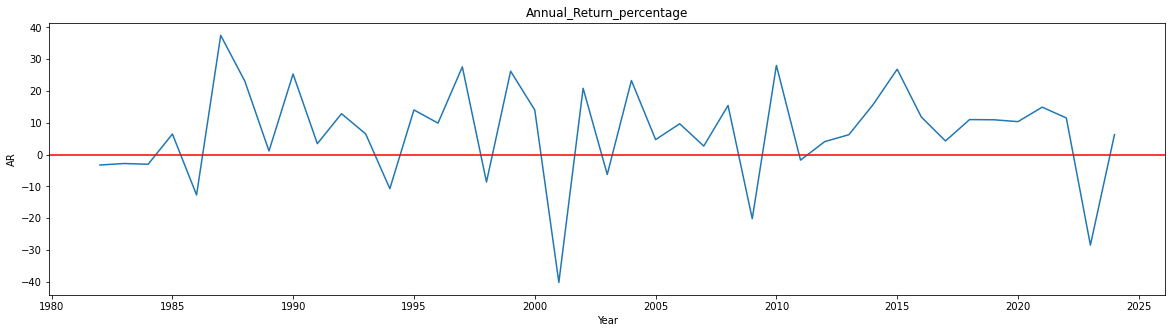

In [10]:
# sets the size of the lineplot
plt.figure(figsize=(20,5));plt.xlabel('Year');plt.ylabel('AR');plt.title('Annual_Return_percentage')
graph = sns.lineplot(data =  Annual_Return_percentage)
graph.axhline(0, color = 'r')
plt.show()

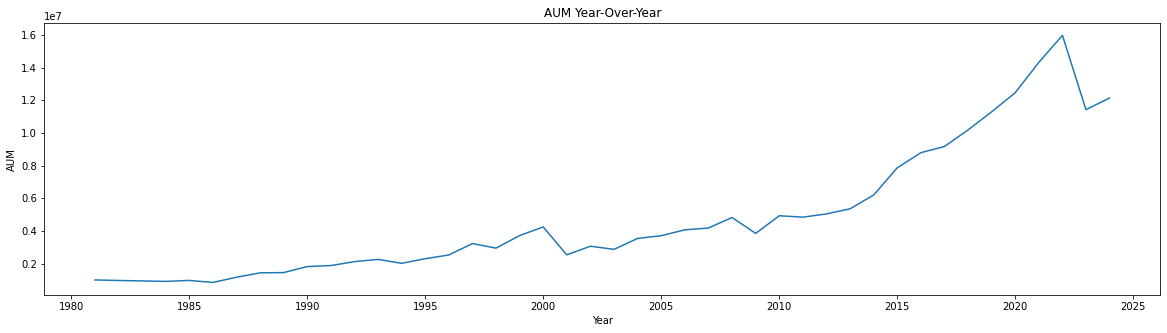

In [11]:
# sets the size of the lineplot
plt.figure(figsize=(20,5));plt.xlabel('Year');plt.ylabel('AUM');plt.title('AUM Year-Over-Year')
sns.lineplot(data = yearly_df.tail(1)["AUM"], markers=True)
plt.show()

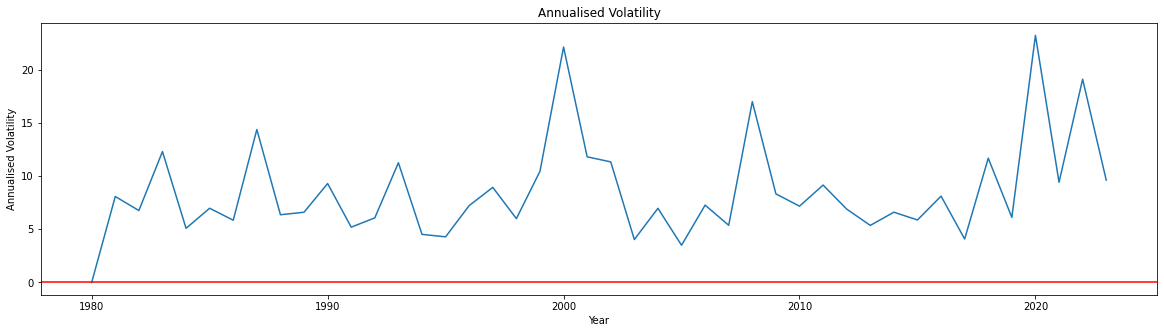

In [12]:
# sets the size of the lineplot
plt.figure(figsize=(20,5));plt.xlabel('Year');plt.ylabel('Annualised Volatility');plt.title('Annualised Volatility')
graph = sns.lineplot(data = Daily_Return_percentage.groupby('year')["AUM"].std() * np.sqrt(252))
graph.axhline(0, color = 'r')
plt.show()

### <B> Further comparisons </B>

In [13]:
# The stock that contributed the most is GOOG. This is done by finding the index of the month with the highest return 
indexmax = (monthly_df.tail(1) - monthly_df.tail(1).shift())["AUM"].argmax()
monthly_df.tail(1)[indexmax:indexmax+1]

shares_monthly_df = shares_df.groupby(pd.Grouper(freq="m"))
shares_monthly_df.tail(1)[indexmax:indexmax+1]

,AAPL,AMZN,GOOG,META,MSFT,NVDA,TSLA
Date,,,,,,,
2020-04-30,0.0,0.0,19221.0,0.0,0.0,0.0,0.0


[*********************100%***********************]  1 of 1 completed
The Ratio of wins over loss for SPY is:  1.4166666666666667


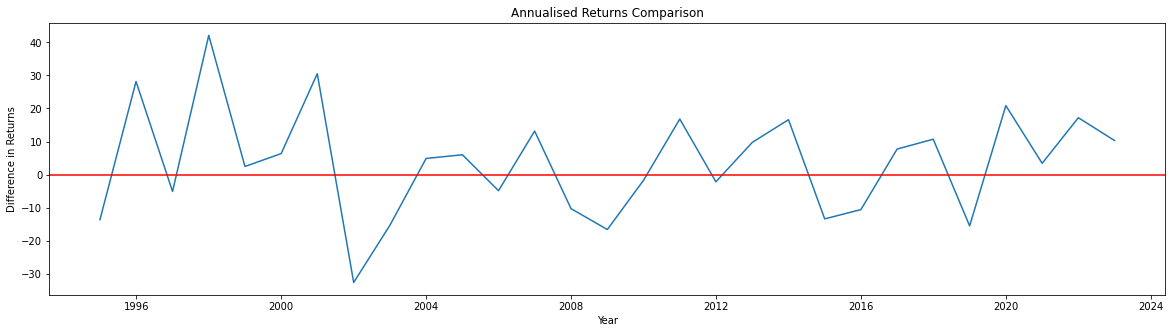

In [21]:
# The portfolio did not outperform the S&P 500. The annualised return is more often than not lower than the S&P500 during the period from 1993 to 2023. 
# S&P500 has higher annualised returns in 18 out of 29 years as given by the spy_win_ratio

spy_df = yf.download('SPY', start='1980-12-12', end='2023-12-29')
yearly_spy_df = spy_df.groupby(pd.Grouper(freq="y"))
spy_annual_returns = ((yearly_spy_df.tail(1) - yearly_spy_df.tail(1).shift())/ yearly_spy_df.tail(1).shift() )["Adj Close"] * 100

Positive = np.sum(np.array(spy_annual_returns - Annual_Return_percentage) > 0, axis=0)
Negative = np.sum(np.array(spy_annual_returns - Annual_Return_percentage) < 0, axis=0)

spy_win_loss_ratio = Positive/Negative
print("The Ratio of wins over loss for SPY is: ",spy_win_loss_ratio)

# Graph for visual representation
plt.figure(figsize=(20,5));plt.xlabel('Year');plt.ylabel('Difference in Returns');plt.title('Annualised Returns Comparison')
graph = sns.lineplot(data =  spy_annual_returns - Annual_Return_percentage)
graph.axhline(0, color = 'r')
plt.show()

##### Remarks
The price index from yahoo gave a peculiar problem where the price for AAPL was 0.00 on 2001-09-12. <br> 
It seems the data is not recorded in yfinance. 
If the values were NAN, it would be fine to use backfill. However, zero price is different. <br>
The biggest reason could be the price data is outdated or old and not used as often and went missing. <br>
Handled in the Data Cleaning section